#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.0 2021-05-05

In [3]:
%pip install --upgrade pip
# Pin a compatible stack for pmdarima wheels
%pip install "numpy<2.0" "scipy<1.11" "pandas<2.2" "Cython<3.0" "setuptools<70"
# Install a matching pmdarima
%pip install "pmdarima==2.0.3"  # 2.0.4 may work too, but this is safest with NumPy<2

Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.9.3.tar.gz (42.1 MB)
ERROR: Operation cancelled by user
^C
Note: you may need to restart the kernel to use updated packages.
  Using cached pmdarima-2.0.3.tar.gz (630 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pmdarima' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pmdarima'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      /tmp/pip-install-5wau48c9/pmdarima_596d69ff4a6c4af09933db05011c6bdd/setup.py:15: UserWarni

In [8]:
import numpy as np, pmdarima as pm
print(np.__version__)
print(pm.__version__)
from pmdarima.arima import auto_arima 

1.26.4
2.0.4


In [6]:
import os
import sys
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")



In [9]:
csv_path = os.path.join("/workspaces/codespaces-jupyter/data/homeprices-data-2000-2018.csv")
data = pd.read_csv(csv_path)
#data = pd.read_csv("https://osf.io/download/n3jty/")

In [10]:
len(data)

228

In [11]:
data.head()

,date,year,month,ps,pn,us,un,emps,empn
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2


In [12]:
data = data.assign(date=lambda x: x.date.str[0:7])
data = data.rename({"pn": "p", "us": "u", "emps": "emp"}, axis=1)

In [13]:
data = data.sort_values(by=["date"]).assign(
    dp=lambda x: x.p.diff(1), # computes the difference between the current value of p and its previous value (p[t] - p[t-1]).
    p_lag=lambda x: x.p.shift(1), # prev value
    lnp=lambda x: np.log(x.p), # log value
    dlnp=lambda x: x.lnp.diff(1), # diff between curr and prev log values
    lnp_lag=lambda x: x.lnp.shift(1),
    dlnp_lag=lambda x: x.dlnp.shift(1),
    du=lambda x: x.u.diff(1),
    lnemp=lambda x: np.log(x.emp),
    dlnemp=lambda x: x.lnemp.diff(1),
    trend=lambda x: range(1, data.shape[0] + 1),
)


In [14]:
data

,date,year,month,ps,p,u,un,emp,empn,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp,trend
0,2000-01,2000,1,101.031209,100.000000,5.0,5.4,14344.4,14132.8,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,9.571115,NaN,1
1,2000-02,2000,2,102.043406,100.618960,5.0,5.3,14390.4,14270.0,0.618960,100.000000,4.611341,0.006171,4.605170,NaN,0.0,9.574317,0.003202,2
2,2000-03,2000,3,103.224699,102.127800,5.0,5.3,14429.1,14421.3,1.508840,100.618960,4.626225,0.014884,4.611341,0.006171,0.0,9.577002,0.002686,3
3,2000-04,2000,4,104.159399,103.704100,5.0,4.7,14484.6,14450.8,1.576300,102.127800,4.641542,0.015317,4.626225,0.014884,0.0,9.580841,0.003839,4
4,2000-05,2000,5,104.924698,104.989080,5.0,4.7,14549.9,14590.2,1.284980,103.704100,4.653856,0.012315,4.641542,0.015317,0.0,9.585339,0.004498,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2018-08,2018,8,281.894600,283.099199,4.2,4.4,17205.7,17149.1,0.183839,282.915360,5.645797,0.000650,5.645148,0.000754,0.0,9.752996,0.002141,224
224,2018-09,2018,9,281.932828,282.529321,4.2,3.9,17242.4,17199.3,-0.569878,283.099199,5.643782,-0.002015,5.645797,0.000650,0.0,9.755127,0.002131,225
225,2018-10,2018,10,282.684714,282.660549,4.3,4.0,17269.8,17371.5,0.131228,282.529321,5.644247,0.000464,5.643782,-0.002015,0.1,9.756715,0.001588,226
226,2018-11,2018,11,282.172804,281.500354,4.3,4.0,17280.0,17474.7,-1.160195,282.660549,5.640134,-0.004113,5.644247,0.000464,0.0,9.757305,0.000590,227


In [15]:
# now save the workfile with data from 2000 through 2018
data.to_pickle("case-shiller-workfile-2000-2018.pkl")

In [16]:
# and now create and save the workfile with data from 2000 through 2017
data = data.loc[lambda x: x.year <= 2017]
data.to_pickle("case-shiller-workfile-2000-2017.pkl")


In [17]:
# Figure 18.8


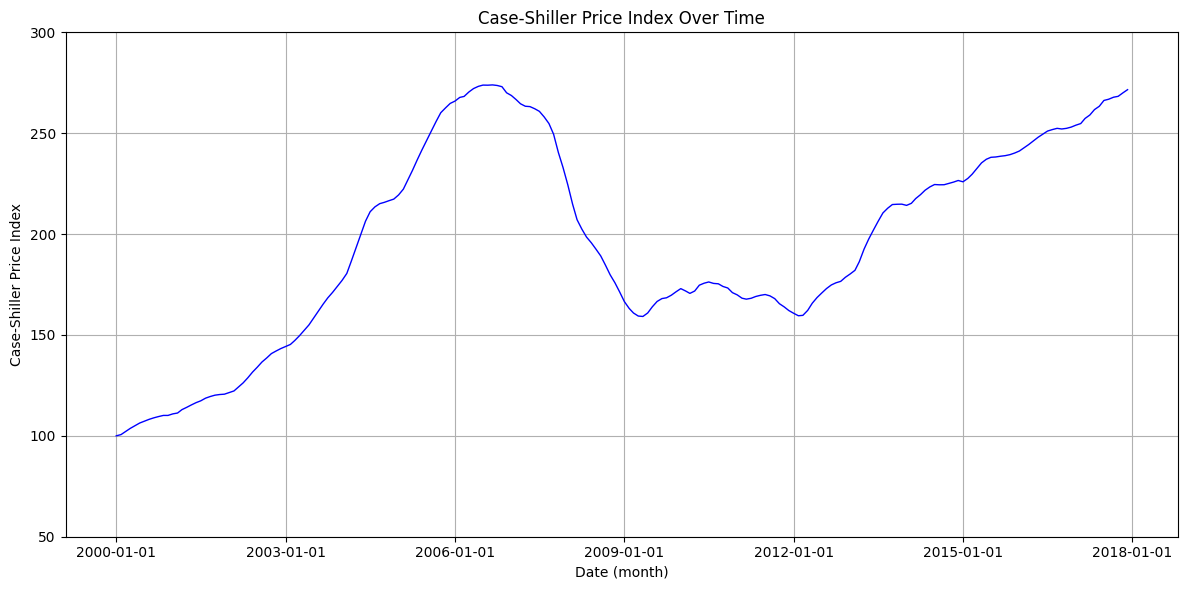

In [18]:
# Convert 'date' column to datetime for proper plotting
data['date'] = pd.to_datetime(data['date'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='p', color='blue', linewidth=1)

# Set plot limits and labels
plt.ylim(50, 300)
plt.yticks(range(50, 301, 50))
plt.xlabel("Date (month)")
plt.ylabel("Case-Shiller Price Index")
plt.title("Case-Shiller Price Index Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

plt.grid(True)
plt.tight_layout()
plt.show()


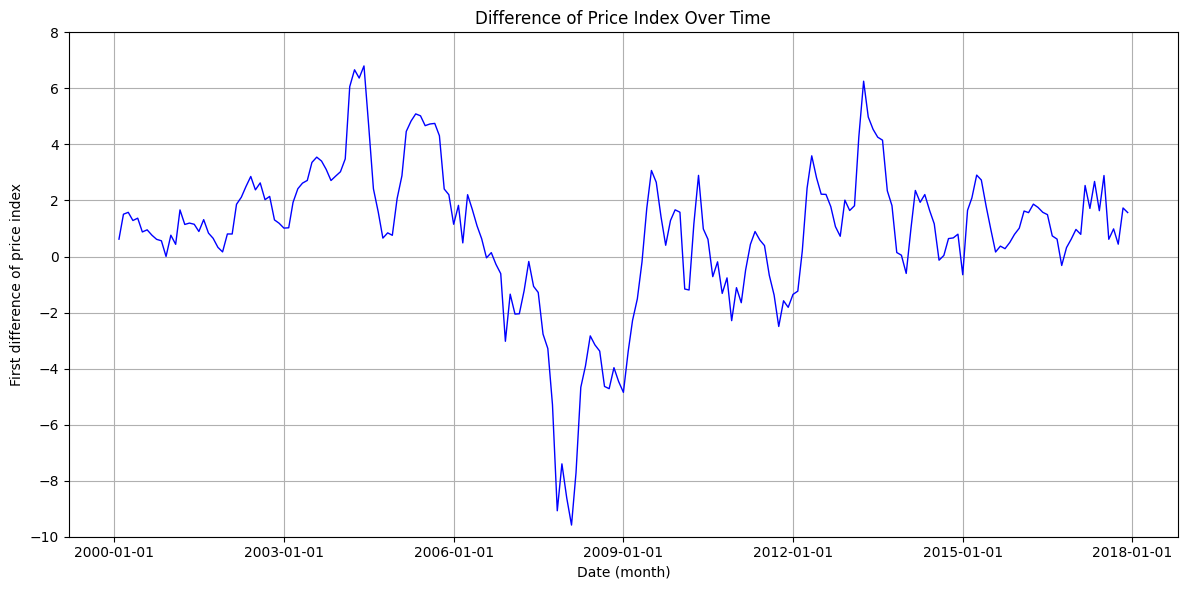

In [19]:
# Additional graphs, not in textbook
# Plot difference of price index

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='dp', color='blue', linewidth=1)

# Set y-axis limits and ticks
plt.ylim(-10, 8)
plt.yticks(range(-10, 9, 2))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("First difference of price index")
plt.title("Difference of Price Index Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


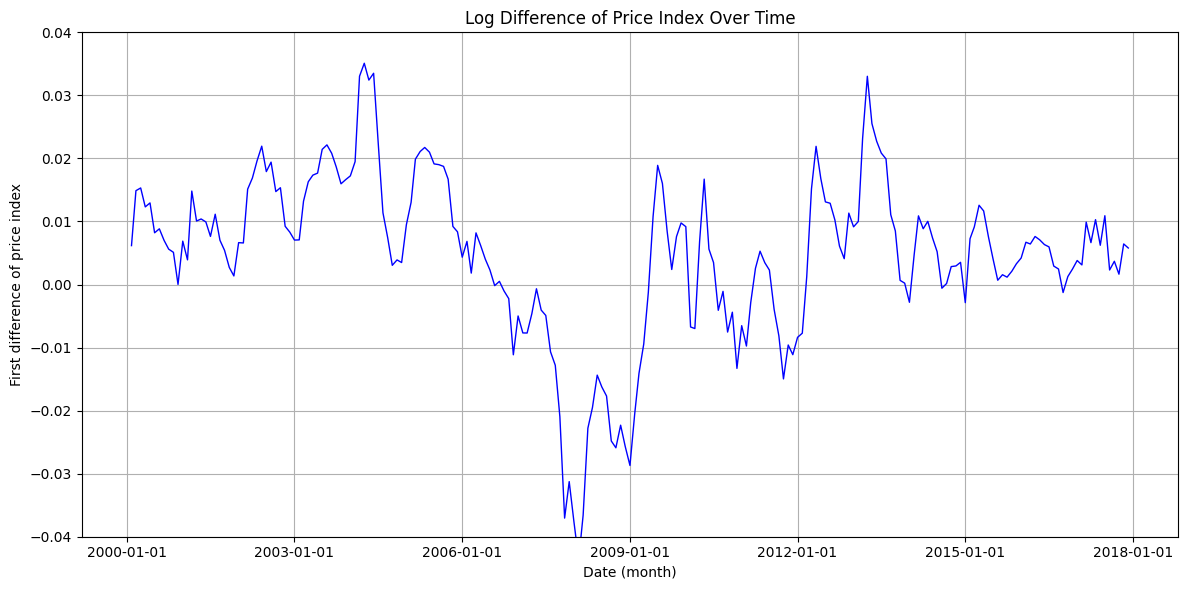

In [20]:
# Additional graphs, not in textbook
# Plot log difference of price index

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='dlnp', color='blue', linewidth=1)

# Set y-axis limits and ticks
plt.ylim(-0.04, 0.04)
plt.yticks(np.arange(-0.04, 0.05, 0.01))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("First difference of price index")
plt.title("Log Difference of Price Index Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


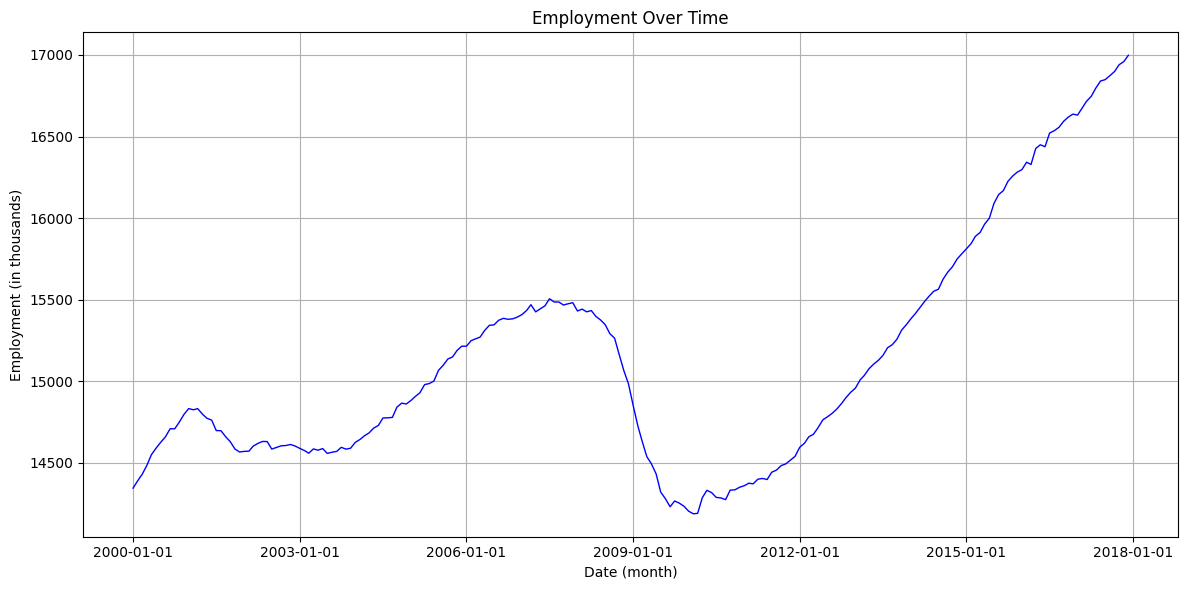

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='emp', color='blue', linewidth=1)


# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("Employment (in thousands)")
plt.title("Employment Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


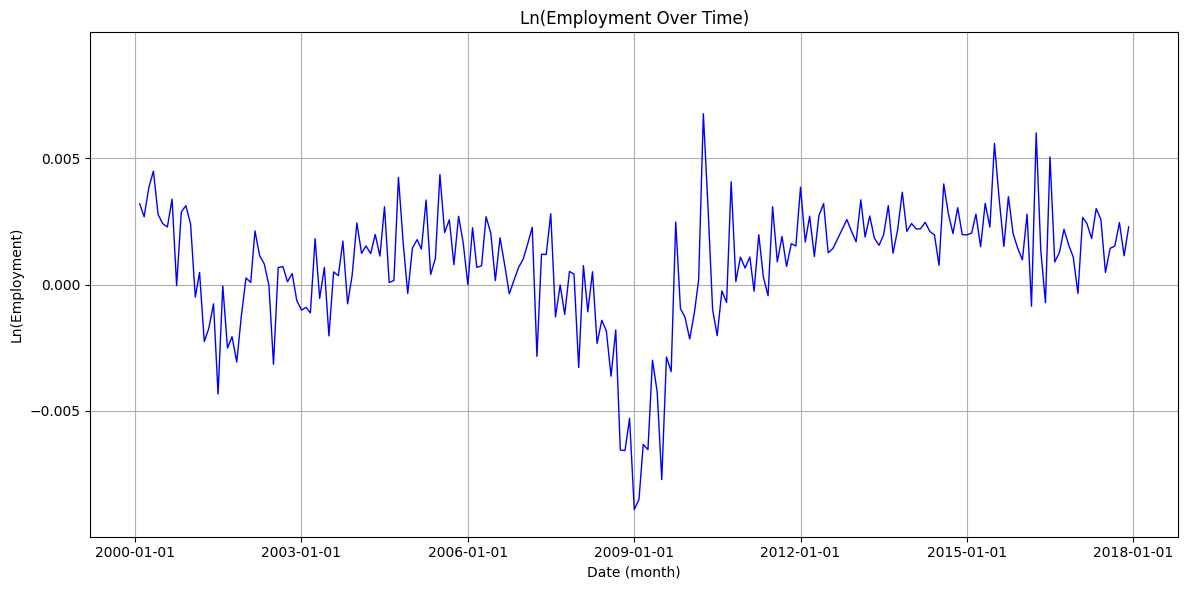

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='dlnemp', color='blue', linewidth=1)

# Set y-axis limits and ticks
plt.ylim(-0.010, 0.010)
plt.yticks(np.arange(-0.005, 0.006, 0.005))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("Ln(Employment)")
plt.title("Ln(Employment Over Time)")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


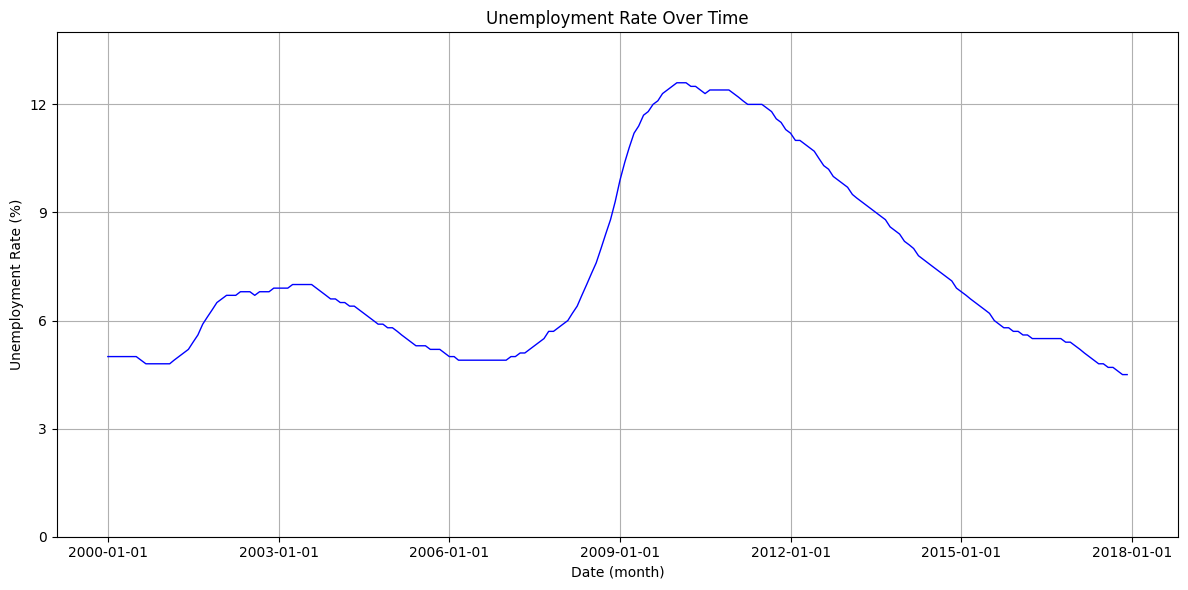

In [23]:
# Plot unemployment rate

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='u', color='blue', linewidth=1)

# Set y-axis limits and ticks
plt.ylim(0, 14)
plt.yticks(np.arange(0, 15, 3))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("Unemployment Rate (%)")
plt.title("Unemployment Rate Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


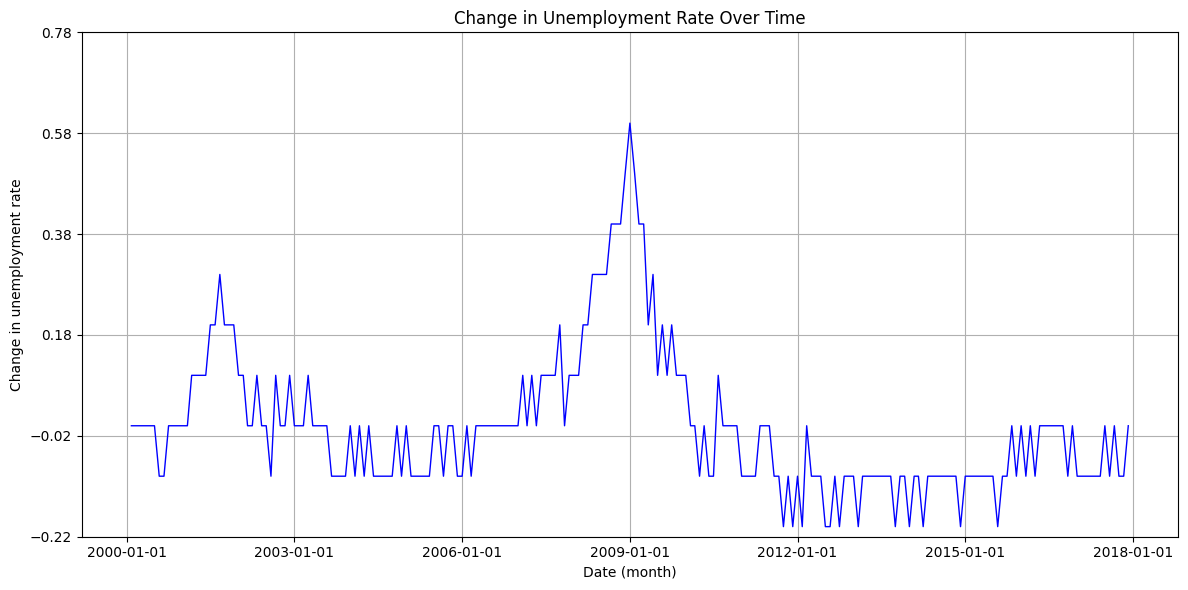

In [24]:
# Plot diff unemployment

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='du', color='blue', linewidth=1)

# Set y-axis limits and ticks
plt.ylim(-0.22, 0.7)
plt.yticks(np.arange(-0.22, 0.8, 0.2))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("Change in unemployment rate")
plt.title("Change in Unemployment Rate Over Time")

# Format x-axis for better readability
plt.xticks(pd.date_range(start='2000-01-01', end='2018-01-01', freq='3YS'))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


### Create work set and holdout set

In [25]:
from datetime import datetime


In [26]:
data["date"] = pd.to_datetime(data["date"], format="%Y-%m")

In [27]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2017, :]
data_work = data.loc[lambda x: x["year"] < 2017, :]

In [28]:
data_work

,date,year,month,ps,p,u,un,emp,empn,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp,trend
0,2000-01-01,2000,1,101.031209,100.000000,5.0,5.4,14344.4,14132.8,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,9.571115,NaN,1
1,2000-02-01,2000,2,102.043406,100.618960,5.0,5.3,14390.4,14270.0,0.618960,100.000000,4.611341,0.006171,4.605170,NaN,0.0,9.574317,0.003202,2
2,2000-03-01,2000,3,103.224699,102.127800,5.0,5.3,14429.1,14421.3,1.508840,100.618960,4.626225,0.014884,4.611341,0.006171,0.0,9.577002,0.002686,3
3,2000-04-01,2000,4,104.159399,103.704100,5.0,4.7,14484.6,14450.8,1.576300,102.127800,4.641542,0.015317,4.626225,0.014884,0.0,9.580841,0.003839,4
4,2000-05-01,2000,5,104.924698,104.989080,5.0,4.7,14549.9,14590.2,1.284980,103.704100,4.653856,0.012315,4.641542,0.015317,0.0,9.585339,0.004498,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2016-08-01,2016,8,250.142796,251.794325,5.5,5.6,16536.0,16469.5,0.736113,251.058212,5.528613,0.002928,5.525685,0.005969,0.0,9.713295,0.000895,200
200,2016-09-01,2016,9,251.460716,252.415221,5.5,5.4,16557.0,16552.6,0.620895,251.794325,5.531075,0.002463,5.528613,0.002928,0.0,9.714564,0.001269,201
201,2016-10-01,2016,10,252.052566,252.095080,5.5,5.3,16593.3,16694.2,-0.320141,252.415221,5.529806,-0.001269,5.531075,0.002463,0.0,9.716754,0.002190,202
202,2016-11-01,2016,11,253.171323,252.413257,5.4,5.1,16619.3,16786.8,0.318177,252.095080,5.531068,0.001261,5.529806,-0.001269,-0.1,9.718320,0.001566,203


In [29]:
data_work["year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016])

In [30]:
# create training and test sets for 4 folds

for year in range(2013, 2017):
    fold = year - 2012 # 4 folds
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (data_work["year"] >= year - 13)

In [31]:
data_work

,date,year,month,ps,p,u,un,emp,empn,dp,...,dlnemp,trend,test1,train1,test2,train2,test3,train3,test4,train4
0,2000-01-01,2000,1,101.031209,100.000000,5.0,5.4,14344.4,14132.8,NaN,...,NaN,1,False,True,False,False,False,False,False,False
1,2000-02-01,2000,2,102.043406,100.618960,5.0,5.3,14390.4,14270.0,0.618960,...,0.003202,2,False,True,False,False,False,False,False,False
2,2000-03-01,2000,3,103.224699,102.127800,5.0,5.3,14429.1,14421.3,1.508840,...,0.002686,3,False,True,False,False,False,False,False,False
3,2000-04-01,2000,4,104.159399,103.704100,5.0,4.7,14484.6,14450.8,1.576300,...,0.003839,4,False,True,False,False,False,False,False,False
4,2000-05-01,2000,5,104.924698,104.989080,5.0,4.7,14549.9,14590.2,1.284980,...,0.004498,5,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2016-08-01,2016,8,250.142796,251.794325,5.5,5.6,16536.0,16469.5,0.736113,...,0.000895,200,False,False,False,False,False,False,True,False
200,2016-09-01,2016,9,251.460716,252.415221,5.5,5.4,16557.0,16552.6,0.620895,...,0.001269,201,False,False,False,False,False,False,True,False
201,2016-10-01,2016,10,252.052566,252.095080,5.5,5.3,16593.3,16694.2,-0.320141,...,0.002190,202,False,False,False,False,False,False,True,False
202,2016-11-01,2016,11,253.171323,252.413257,5.4,5.1,16619.3,16786.8,0.318177,...,0.001566,203,False,False,False,False,False,False,True,False


In [32]:
data_work[data_work["year"] == 2013]

,date,year,month,ps,p,u,un,emp,empn,dp,...,dlnemp,trend,test1,train1,test2,train2,test3,train3,test4,train4
156,2013-01-01,2013,1,182.183984,180.22965,9.7,10.3,14957.2,14796.1,1.64208,...,0.001693,157,True,False,False,True,False,True,False,True
157,2013-02-01,2013,2,184.874883,182.04080,9.5,9.8,15007.5,14921.8,1.81115,...,0.003357,158,True,False,False,True,False,True,False,True
158,2013-03-01,2013,3,188.974529,186.30325,9.4,9.5,15035.8,14999.8,4.26245,...,0.001884,159,True,False,False,True,False,True,False,True
159,2013-04-01,2013,4,193.855699,192.55935,9.3,8.8,15076.7,15065.0,6.25610,...,0.002716,160,True,False,False,True,False,True,False,True
160,2013-05-01,2013,5,196.945168,197.53669,9.2,8.7,15104.5,15148.1,4.97734,...,0.001842,161,True,False,False,True,False,True,False,True
161,2013-06-01,2013,6,200.333070,202.07630,9.1,9.4,15128.0,15178.6,4.53961,...,0.001555,162,True,False,False,True,False,True,False,True
162,2013-07-01,2013,7,203.841451,206.33463,9.0,9.4,15157.8,15032.3,4.25833,...,0.001968,163,True,False,False,True,False,True,False,True
163,2013-08-01,2013,8,207.929952,210.48633,8.9,9.0,15205.3,15145.7,4.15170,...,0.003129,164,True,False,False,True,False,True,False,True
164,2013-09-01,2013,9,210.766271,212.83120,8.8,8.6,15224.2,15200.6,2.34487,...,0.001242,165,True,False,False,True,False,True,False,True
165,2013-10-01,2013,10,213.689025,214.64741,8.6,8.6,15257.1,15344.3,1.81621,...,0.002159,166,True,False,False,True,False,True,False,True


In [33]:
data_work[data_work["train1"] == True]

,date,year,month,ps,p,u,un,emp,empn,dp,...,dlnemp,trend,test1,train1,test2,train2,test3,train3,test4,train4
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8,NaN,...,NaN,1,False,True,False,False,False,False,False,False
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0,0.61896,...,0.003202,2,False,True,False,False,False,False,False,False
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3,1.50884,...,0.002686,3,False,True,False,False,False,False,False,False
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8,1.57630,...,0.003839,4,False,True,False,False,False,False,False,False
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2,1.28498,...,0.004498,5,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2012-08-01,2012,8,170.649259,173.00625,10.3,10.6,14802.6,14737.5,2.21602,...,0.001426,152,False,True,False,True,False,True,False,True
152,2012-09-01,2012,9,172.711556,174.78626,10.2,9.8,14829.4,14803.1,1.78001,...,0.001809,153,False,True,False,True,False,True,False,True
153,2012-10-01,2012,10,174.790993,175.85370,10.0,9.8,14861.9,14945.7,1.06744,...,0.002189,154,False,True,False,True,False,True,False,True
154,2012-11-01,2012,11,176.542913,176.57595,9.9,9.5,14900.2,15061.5,0.72225,...,0.002574,155,False,True,False,True,False,True,False,True


In [34]:
data_work[data_work["train2"] == True]

,date,year,month,ps,p,u,un,emp,empn,dp,...,dlnemp,trend,test1,train1,test2,train2,test3,train3,test4,train4
12,2001-01-01,2001,1,112.031476,110.88080,4.8,5.3,14832.3,14619.9,0.76038,...,0.002396,13,False,True,False,True,False,False,False,False
13,2001-02-01,2001,2,112.902899,111.31561,4.8,5.1,14824.9,14708.2,0.43481,...,-0.000499,14,False,True,False,True,False,False,False,False
14,2001-03-01,2001,3,114.178497,112.97801,4.9,5.3,14832.0,14826.3,1.66240,...,0.000479,15,False,True,False,True,False,False,False,False
15,2001-04-01,2001,4,114.636796,114.12192,5.0,4.9,14798.5,14765.9,1.14391,...,-0.002261,16,False,True,False,True,False,False,False,False
16,2001-05-01,2001,5,115.257389,115.31479,5.1,4.6,14772.8,14815.0,1.19287,...,-0.001738,17,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2013-08-01,2013,8,207.929952,210.48633,8.9,9.0,15205.3,15145.7,4.15170,...,0.003129,164,True,False,False,True,False,True,False,True
164,2013-09-01,2013,9,210.766271,212.83120,8.8,8.6,15224.2,15200.6,2.34487,...,0.001242,165,True,False,False,True,False,True,False,True
165,2013-10-01,2013,10,213.689025,214.64741,8.6,8.6,15257.1,15344.3,1.81621,...,0.002159,166,True,False,False,True,False,True,False,True
166,2013-11-01,2013,11,215.073784,214.78954,8.5,8.3,15313.1,15482.3,0.14213,...,0.003664,167,True,False,False,True,False,True,False,True


In [35]:
data_work["year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016])

In [36]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

In [37]:
# Model M1
# p on trend & seasonality
mse_1 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model1 = smf.ols("p ~ trend + C(month)", train_data).fit()

    phat = model1.predict(test_data)

    errsq = np.square(test_data.p.values - phat)

    mse_1.append(np.mean(errsq))

rmse_cv_m1 = np.sqrt(np.mean(mse_1))
rmse_cv_m1


31.92505512782132

In [ ]:
# Model M2
# p ARIMA(1,1,2)

# Get order from auto_arima

auto_arima_m2 = auto_arima(
    y=data_work.p, # Y prediction
    start_p=0, # With start_p=0, the algorithm can test AR(0), AR(1), AR(2), AR(3)… so it usually finds the simpler correct model.
               # With start_p=2, the algorithm doesn’t check AR(0) or AR(1), so it might “jump” to AR(2) even if AR(1) is better.

    max_p=1,  # AR = 1; Without this constrain, python returns other ARIMA order
    max_order=0, # p + q + P + Q <= 0
    seasonal=False,
)

mse_2 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model2 = ARIMA(train_data.p, order=auto_arima_m2.get_params()["order"]).fit()

    phat = model2.forecast(steps=12)

    errsq = np.square(test_data.p.values - phat)

    mse_2.append(np.mean(errsq))

rmse_cv_m2 = np.sqrt(np.mean(mse_2))
rmse_cv_m2


9.478034444013892

In [69]:
# Another way 
order_m2 = (1, 1, 2)  

mse_2 = []
for i in range(1, 5):
    train_mask = data_work["train" + str(i)] == 1
    test_mask  = data_work["test"  + str(i)] == 1

    y_train = data_work.loc[train_mask, "p"]
    y_test  = data_work.loc[test_mask,  "p"]

    # make sure index is monotonic (good practice for forecasting)
    y_train = y_train.sort_index()
    y_test  = y_test.sort_index()

    # fit on train
    model2 = ARIMA(endog=y_train, order=order_m2).fit()

    # forecast exactly len(test) steps
    phat = model2.forecast(steps=len(y_test))

    # MSE for this fold
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
rmse_cv_m2

9.478034444013892

In [74]:
y_train

36     144.271850
37     145.296630
38     147.230210
39     149.648710
40     152.267450
          ...    
187    238.222875
188    238.593426
189    238.872584
190    239.375900
191    240.164965
Name: p, Length: 156, dtype: float64

In [72]:
y_test 

192    241.177126
193    242.800052
194    244.365985
195    246.235291
196    247.987387
197    249.564000
198    251.058212
199    251.794325
200    252.415221
201    252.095080
202    252.413257
203    253.028168
Name: p, dtype: float64

In [70]:
phat

156    240.963880
157    241.711474
158    242.371850
159    242.955183
160    243.470461
161    243.925624
162    244.327685
163    244.682840
164    244.996560
165    245.273680
166    245.518469
167    245.734700
Name: predicted_mean, dtype: float64

In [71]:
y_test.values

array([241.17712558, 242.80005178, 244.36598545, 246.23529125,
       247.98738725, 249.56400049, 251.05821215, 251.79432541,
       252.41522061, 252.09507982, 252.41325731, 253.02816777])

In [55]:
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      p   No. Observations:                  156
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -229.908
Date:                Thu, 21 Aug 2025   AIC                            467.817
Time:                        18:27:05   BIC                            479.991
Sample:                             0   HQIC                           472.762
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8833      0.040     21.858      0.000       0.804       0.963
ma.L1          0.2366      0.082      2.898      0.004       0.077       0.397
ma.L2          0.1381      0.086      1.598      0.1

In [39]:
# Model M3
# p ARIMA(1,1,0)
# Get order from auto_arima
# build the (numeric) dummy matrix once
month_dum = pd.get_dummies(data_work["month"], drop_first=True, dtype=int)

# get order from auto_arima
auto_arima_m3 = auto_arima(
    y=data_work["p"].values,
    X=month_dum.values,
    seasonal=False,
    max_order=0,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
)
order_m3 = auto_arima_m3.order

mse_3 = []
for i in range(1, 5):
    train_mask = data_work["train" + str(i)] == 1
    test_mask  = data_work["test"  + str(i)] == 1

    y_train = data_work.loc[train_mask, "p"]
    y_test  = data_work.loc[test_mask,  "p"]

    X_train = month_dum.loc[train_mask]
    X_test  = month_dum.loc[test_mask]

    # (safety) align columns just in case
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    model3 = ARIMA(endog=y_train, exog=X_train, order=order_m3).fit()

    phat = model3.forecast(steps=len(y_test), exog=X_test)  # same number of steps as test

    errsq = (y_test.values - phat.values)**2
    mse_3.append(np.mean(errsq))

rmse_cv_m3 = float(np.sqrt(np.mean(mse_3)))
rmse_cv_m3

4.116839619034775

In [63]:
data_work.p,

(0      100.000000
 1      100.618960
 2      102.127800
 3      103.704100
 4      104.989080
           ...    
 199    251.794325
 200    252.415221
 201    252.095080
 202    252.413257
 203    253.028168
 Name: p, Length: 204, dtype: float64,)

In [64]:
len(data_work["p"].values)

204

In [ ]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

# Get order from auto_arima
auto_arima_m4 = auto_arima(
    y=data_work.p,
    X=pd.get_dummies(data_work.month).assign(t=data_work.trend),
    max_order=0,
    seasonal=False,
)

mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model4 = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month),
        trend="t",
        order=auto_arima_m4.get_params()["order"],
    ).fit()

    phat = model4.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))


In [54]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

month_dum = pd.get_dummies(data_work["month"], drop_first=True, dtype=int)
# Get order from auto_arima
auto_arima_m4 = auto_arima(
    y=data_work.p,
    X=month_dum,
    max_order=0,
    seasonal=False,
)

mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    # Ensure exog data is numeric and aligned
    exog_train = pd.get_dummies(train_data.month, drop_first=False).astype(float)
    exog_test = pd.get_dummies(test_data.month, drop_first=False).astype(float)

    # Align columns of exog_test with exog_train
    exog_test = exog_test.reindex(columns=exog_train.columns, fill_value=0)

    model4 = ARIMA(
        train_data.p,
        exog=exog_train,
        trend="t",
        order=auto_arima_m4.get_params()["order"],
    ).fit()

    phat = model4.forecast(steps=12, exog=exog_test)

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))
rmse_cv_m4 

4.452854630290868

In [48]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

# Get order from auto_arima
auto_arima_m4 = auto_arima(
    y=data_work.p,
    X=pd.get_dummies(data_work.month).assign(t=data_work.trend),
    max_order=0,
    seasonal=False,
)

mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model4 = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month),
        trend="t",
        order=auto_arima_m4.get_params()["order"],
    ).fit()

    phat = model4.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [47]:
from pmdarima.arima import auto_arima

# exog must be numeric
exog_all = pd.get_dummies(data_work['month'], drop_first=False).rename(columns=str).astype(float)

auto_arima_m4 = auto_arima(
    y=data_work['p'],
    X=exog_all,
    d=0,                 # you want ARIMA(*,0,*)
    start_p=0, max_p=2,  # let it search AR order up to 2
    start_q=0, max_q=0,  # no MA terms
    seasonal=False,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True
)

print("Chosen order:", auto_arima_m4.order)

mse_4 = []
for i in range(1, 5):
    train_idx = data_work.index[data_work[f"train{i}"] == 1]
    test_idx  = data_work.index[data_work[f"test{i}"] == 1]

    y_train = data_work.loc[train_idx, 'p']
    y_test  = data_work.loc[test_idx,  'p']
    exog_train = exog_all.loc[train_idx]
    exog_test  = exog_all.loc[test_idx]

    model4 = ARIMA(
        endog=y_train,
        order=auto_arima_m4.order,
        exog=exog_train,
        trend='t'
    ).fit()

    phat = model4.forecast(steps=len(test_idx), exog=exog_test)

    mse_4.append(((y_test.values - phat.values) ** 2).mean())

rmse_cv_m4 = float(np.sqrt(np.mean(mse_4)))
print("RMSE (CV) M4:", rmse_cv_m4)

Chosen order: (0, 0, 0)
RMSE (CV) M4: 31.925667306928656


In [ ]:
# Model M5
# dp ~ month + trend, without any ARIMA

mse_5 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model5 = smf.ols("dp ~ trend + C(month)", train_data).fit()

    dphat = model5.predict(test_data)

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat.iloc[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat.iloc[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_5.append(np.mean(errsq))

rmse_cv_m5 = np.sqrt(np.mean(mse_5))


In [ ]:
# Model M6
# lnp ARIMA(0,2,0) + seasonality

# Get order from auto_arima
auto_arima_m6 = auto_arima(
    y=data_work.lnp,
    X=pd.get_dummies(data_work.month),
    d=2,  # without this constrain, python returns other ARIMA order
    max_order=0,
    seasonal=True,
)

mse_6 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model6 = ARIMA(
        train_data.lnp,
        exog=pd.get_dummies(train_data.month),
        order=auto_arima_m6.get_params()["order"],
    ).fit()

    lnphat = model6.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    corrb = mean_squared_error(test_data.lnp, lnphat)

    phat = np.exp((lnphat + corrb / 2))

    errsq = np.square(test_data.p.values - phat)

    mse_6.append(np.mean(errsq))

rmse_cv_m6 = np.sqrt(np.mean(mse_6))


In [ ]:
# VAR

mse_var = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7 = VAR(train_data[["dp", "du", "dlnemp"]]).fit(1)

    dphat = model7.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7.k_ar :], steps=12
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse_var))


In [ ]:
# Note. This VAR includes month dummies
# Textbook results are from R, where
# we could not figure out how to inlcude month dummies

mse_var_season = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7_season = VAR(
        train_data[["dp", "du", "dlnemp"]], exog=pd.get_dummies(train_data["month"])
    ).fit(1)

    dphat = model7_season.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7_season.k_ar :],
        exog_future=pd.get_dummies(test_data["month"]).values,
        steps=12,
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var_season.append(np.mean(errsq))

rmse_cv_m7_season = np.sqrt(np.mean(mse_var_season))


In [ ]:
# Note: some model's cv rmse differns from textbook

pd.DataFrame(
    [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_var],
    columns=["Fold" + str(i) for i in range(1, 5)],
).apply(np.sqrt).assign(
    Average=[
        rmse_cv_m1,
        rmse_cv_m2,
        rmse_cv_m3,
        rmse_cv_m4,
        rmse_cv_m5,
        rmse_cv_m6,
        rmse_cv_m7,
    ],
    model=["M" + str(i) for i in range(1, 7)] + ["M7 (var)"],
).round(
    2
).set_index(
    "model"
)


,Fold1,Fold2,Fold3,Fold4,Average
model,,,,,
M1,14.90,17.59,34.43,48.58,31.93
M2,14.82,8.39,6.23,5.53,9.48
M3,6.68,1.39,3.28,3.22,4.11
M4,3.00,1.24,1.37,2.03,2.04
M5,33.94,9.79,10.42,7.39,18.78
M6,2.52,4.92,9.31,9.73,7.28
M7 (var),13.90,6.33,3.40,3.63,8.03


In [ ]:
print("RMSE for VAR with seasonality (not in book):", rmse_cv_m7_season)


RMSE for VAR with seasonality (not in book): 4.531352403195174


### predict for holdout

In [ ]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month), trend="t", order=(2, 0, 0)
).fit()


In [ ]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)


In [ ]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)


In [ ]:
data_plot = (
    data.join(forecast_holdout_best)
    .loc[lambda x: x.year >= 2015]
    .reset_index(drop=True)
)


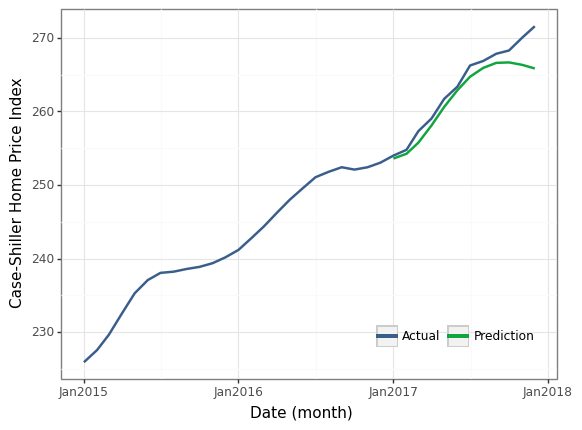

<ggplot: (381998891)>

In [ ]:
data_plot_1 = pd.melt(data_plot.filter(["date", "p", "p_pred"]), ["date"])

pred_p_plot = (
    ggplot(data_plot_1, aes(x="date", y="value", color="variable"))
    + geom_line(size=1)
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(
        legend_position=(0.74, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)
pred_p_plot

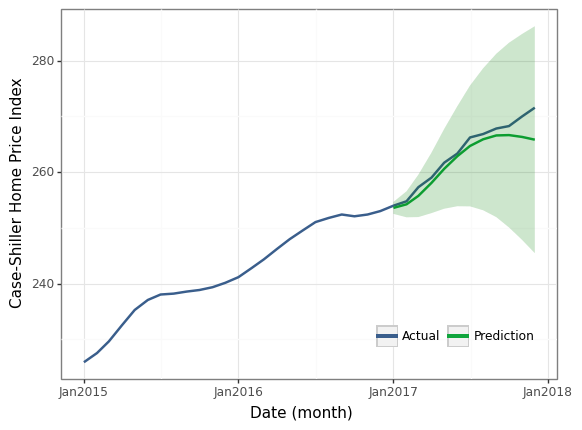

<ggplot: (393653239)>

In [ ]:
data_plot_2 = pd.melt(
    data_plot.filter(["date", "p", "p_pred", "lower p", "upper p"]),
    ["date", "lower p", "upper p"],
)

pred_p_plot = (
    ggplot(data_plot_2, aes(x="date", y="value", color="variable", group="variable"))
    + geom_line(size=1)
    + geom_ribbon(
        aes(ymin="lower p", ymax="upper p"),
        fill="green",
        color=None,
        alpha=0.1,
    )
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(
        legend_position=(0.74, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)
pred_p_plot

In [ ]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout


4.924744472466786

### EXTERNAL VALIDITY
### do the prediction for an extra year

In [ ]:
data = pd.read_pickle("case-shiller-workfile-2000-2018.pkl")


In [ ]:
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m"))


In [ ]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2018, :]
data_work = data.loc[lambda x: x["year"] < 2018, :]


In [ ]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month), trend="t", order=(2, 0, 0)
).fit()


In [ ]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)


In [ ]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)


In [ ]:
data_plot = (
    data.join(forecast_holdout_best)
    .loc[lambda x: x.year >= 2015]
    .reset_index(drop=True)
)


## Figure 18.11 Prediction on new holdout

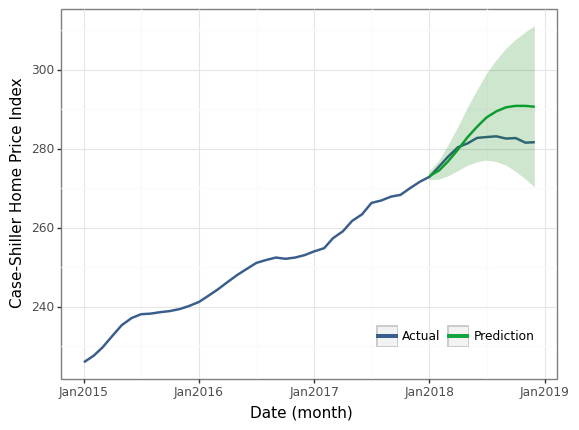

<ggplot: (393701102)>

In [ ]:
data_plot_2 = pd.melt(
    data_plot.filter(["date", "p", "p_pred", "lower p", "upper p"]),
    ["date", "lower p", "upper p"],
)

pred_p_plot = (
    ggplot(data_plot_2, aes(x="date", y="value", color="variable", group="variable"))
    + geom_line(size=1)
    + geom_ribbon(
        aes(ymin="lower p", ymax="upper p"), fill="green", color=None, alpha=0.1
    )
    + ylab("Case-Shiller Home Price Index")
    + xlab("Date (month)")
    + scale_color_manual(
        name=" ", values=(color[0], color[1]), labels=("Actual", "Prediction")
    )
    + scale_x_date(date_breaks="1 years", labels=date_format("%b%Y"))
    + theme_bw()
    + theme(
        legend_position=(0.74, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)
pred_p_plot

In [ ]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout


31.170744959848065